# Visualizing heatwaves with complex networks using E-OBS' `'tx'` data
### — A use case for the 2003 heatwave (*and potentially others!*)

This is a notebook wrapping the functionalities of `heatwaves.py`, our toy-engine to visualize the movement of heatwaves in Europe. Please, check the file `read_the_doc.md` for a longer description of each of the functions inside `heatwave.py`. The current notebook is prepared to read the E-OBS volume and run a Complex Network analysis for a selected period during a severe heatwave. This analysis computes five network coefficients, which are later interactively visualized (and stored as PNGs and netcdf). The analysis can be run for three selected regions, named: `Iberia`, `Mediterranean`, `Europe`. Note that the temporal cost of running the analysis is `Iberia: ~1m`, `Mediterranean: ~5m`, `Europe: ~3h`.



Loading the `heatwaves.py` module and setting up some basic parameters. Here the extent_name can be change to any of the three explained above. The corresponding `extent` will be fetched and used throughout the process.

In [1]:
import sys
sys.path.append('/visualization-heatwaves')
from heatwaves import *

# Parameters associated to a particular experiment
extent_name = "Iberia"
resolution = "0.5deg"
left, right, north, south = get_bounds_for_extent_name(extent_name)
months_of_interest = [6, 7, 8, 9]

# The heatwave period
sd = datetime(2003, 7, 28)
ed = datetime(2003, 8, 17)

# An alternative heatwave period; also tested (to some extent)
# sd = datetime(2003, 6, 1)
# ed = datetime(2003, 7, 1)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


Setting up some paths for the I/O

In [2]:
# Loading the dataset, spanning from 1951-2021
where = "kubernetes"

if where == "local":
    path_in_temp = r"/media/garciama/Elements/data/geodata/raster/KNMI/E-OBS_Heatwaves/tx_ens_mean_0.50deg_reg_v26.0e.nc"
    path_png_out = r"/home/garciama/Pictures/Projects/vis-heatwaves-test/"
    path_nc_out = r"/media/garciama/Elements/data/projects/vis-heatwaves/{0}"

elif where == "kubernetes":
    path_in_temp = r"/home/jovyan/work/visualization-heatwaves/tx_ens_mean_0.50deg_reg_v26.0e.nc"
    path_png_out = r"/home/jovyan/work/visualization-heatwaves/out_folder_png/{0}"
    path_nc_out = r"/home/jovyan/work/visualization-heatwaves/out_folder_nc/{0}"
    
elif where == "workstation":
    path_in_temp = r"/run/media/garciama/Elements/data/geodata/raster/KNMI/E-OBS_Heatwaves/tx_ens_mean_0.50deg_reg_v26.0e.nc"
    path_png_out = r""
    path_nc_out = r""

Now we read the E-OBS `tx` volume and print it to make sure it is what it should be

In [3]:
dataset = xr.open_dataset(path_in_temp, decode_times=True, use_cftime=True)
print(dataset)

<xarray.Dataset>
Dimensions:  (time: 26479, lon: 100, lat: 73)
Coordinates:
  * time     (time) object 1950-01-01 00:00:00 ... 2022-06-30 00:00:00
  * lon      (lon) float64 -9.75 -9.25 -8.75 -8.25 ... 38.25 38.75 39.25 39.75
  * lat      (lat) float64 35.25 35.75 36.25 36.75 ... 69.75 70.25 70.75 71.25
Data variables:
    tx       (time, lat, lon) float64 ...
Attributes:
    CDI:            Climate Data Interface version 2.0.3 (https://mpimet.mpg....
    Conventions:    CF-1.4
    E-OBS_version:  26.0e
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Thu Nov 03 15:08:49 2022: cdo -L -b 64 sellonlatbox,-10,4...
    NCO:            netCDF Operators version 4.7.5 (Homepage = http://nco.sf....
    CDO:            Climate Data Operators version 2.0.3 (https://mpimet.mpg....


Out of all coordinate pairs in the E-OBS volume, get only the ones pertaining to `extent_name`

In [4]:
# Fetching all lats/lons in the file
lats = dataset["lat"]
lons = dataset["lon"]

# Packing all lats/lons inside one of the predefined bounding boxes
lons_mask = ((lons >= left) & (lons <= right))
lats_mask = ((lats >= south) & (lats <= north))
lats_bbox = lats[lats_mask]
lons_bbox = lons[lons_mask]
all_coords_bbox = [lats_bbox, lons_bbox]
dimensions_board = (len(lats_bbox), len(lons_bbox))
print("Dimensions of analysis: ", dimensions_board)

# Find out the limits of the bounding box
min_lon, max_lon = [np.amin(lons_bbox), np.amax(lons_bbox)]
min_lat, max_lat = [np.amin(lats_bbox), np.amax(lats_bbox)]
bounds = [min_lat, max_lat, min_lon, max_lon]

Dimensions of analysis:  (20, 30)


Now the modelling with complex network starts; has three parts:
- `heatwave calculation`: Deciding whether or not a pixel on a particular day belongs to a heatwave 
- `event synchronization`: Pipeline to transform the binary `heatwave calculation` into a pair of adjancency matrices
- `complex network modelling`: Computes the directed and undirected graphs and provides five network coefficients

**Note**: Only execute the visualization cell when the next one prints the execution time

In [5]:
# Starting modelling
start = timeit.default_timer()
heatwaves = heatwave_calc(sd, ed, dataset, bounds, dimensions_board)
dic_A_Q, dic_A_q = eventsync_calc(sd, ed, heatwaves)
dic_cn_coefs = complexnetwork_modelling(sd, ed, dic_A_Q, dic_A_q)
dic_stacks, pack_summary_coefs = complexnetwork_summary_coefs(sd, ed, dic_cn_coefs, all_coords_bbox)
stop = timeit.default_timer()
print('Time: ', stop - start, 'seconds')


Time:  76.17337826220319 seconds


With the results in place, now visualization can begin! This function divides the heatwave period in 4 parts and calculates the average of the coefficients. Like this it is possible to see how the heatwave evolved, as 'seen' by each coefficient.

Unrecognized backend:  module://matplotlib_inline.backend_inline


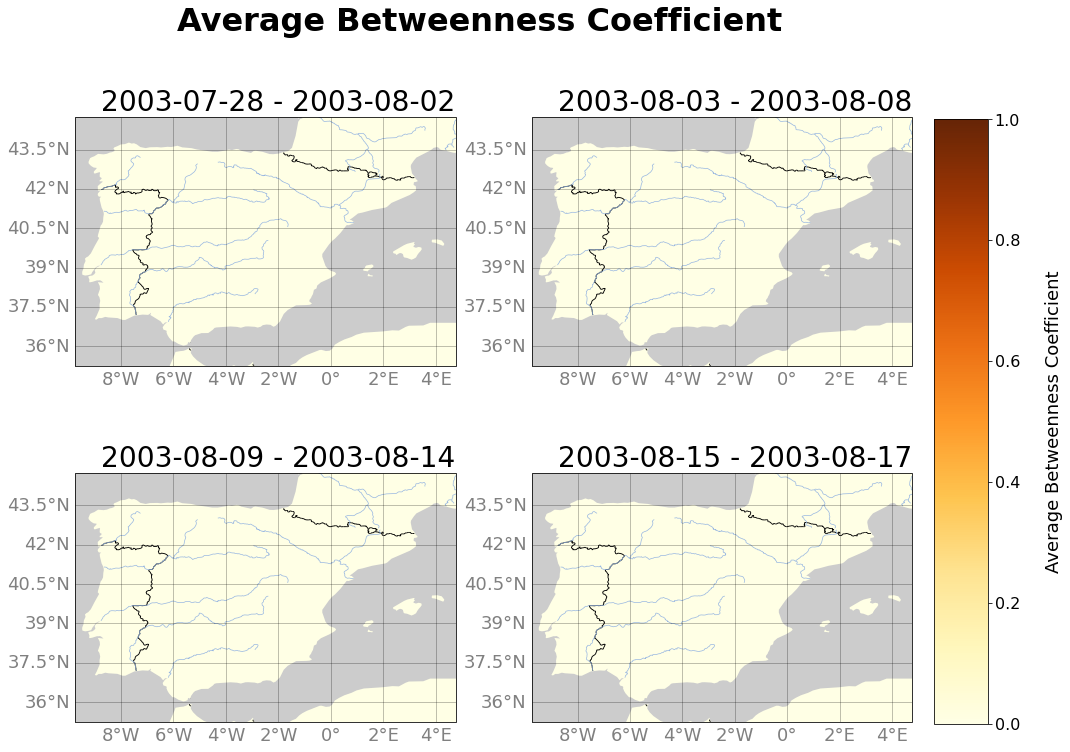

Unrecognized backend:  module://matplotlib_inline.backend_inline


<Figure size 432x288 with 0 Axes>

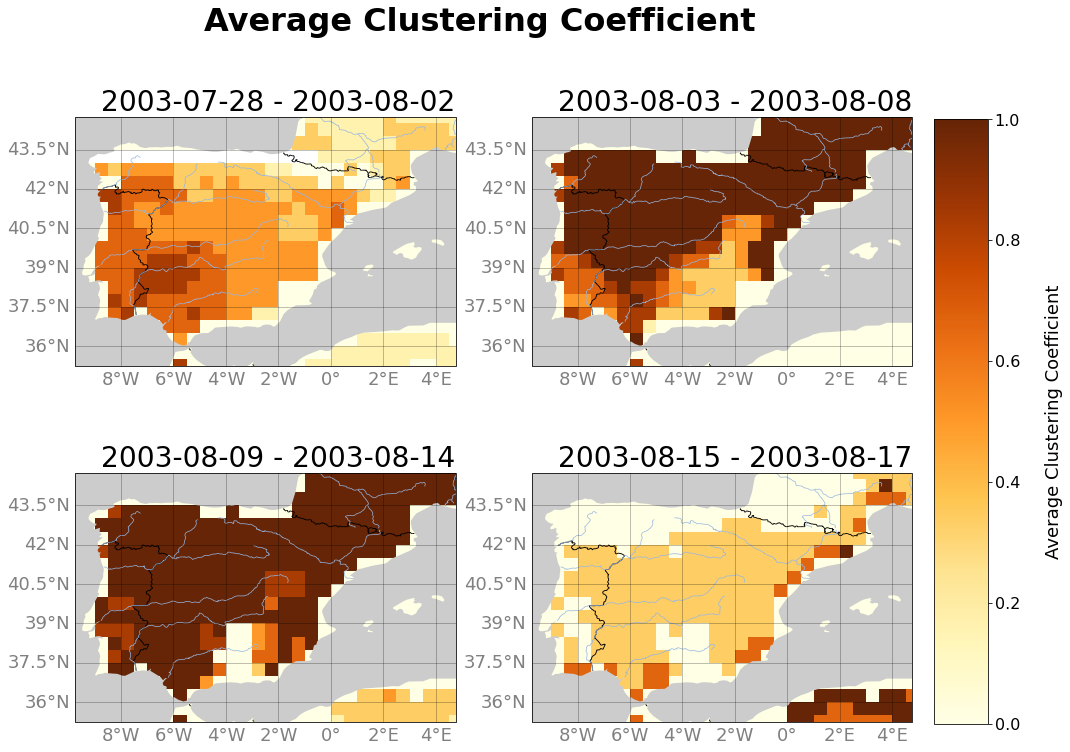

Unrecognized backend:  module://matplotlib_inline.backend_inline


<Figure size 432x288 with 0 Axes>

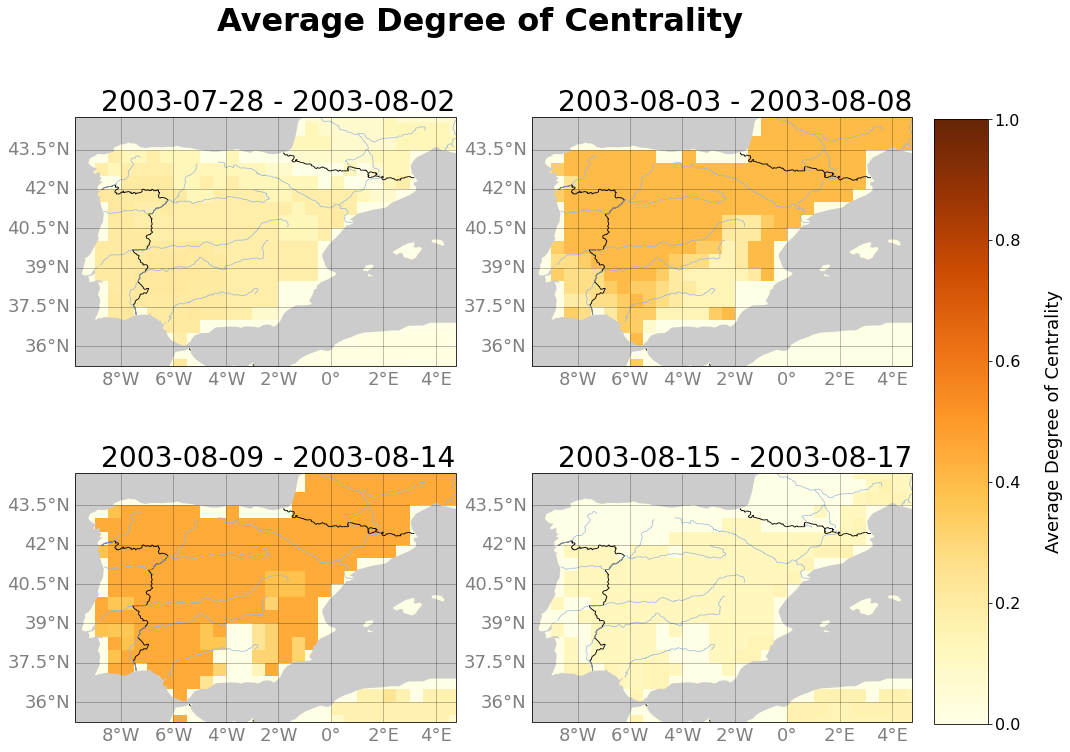

Unrecognized backend:  module://matplotlib_inline.backend_inline


<Figure size 432x288 with 0 Axes>

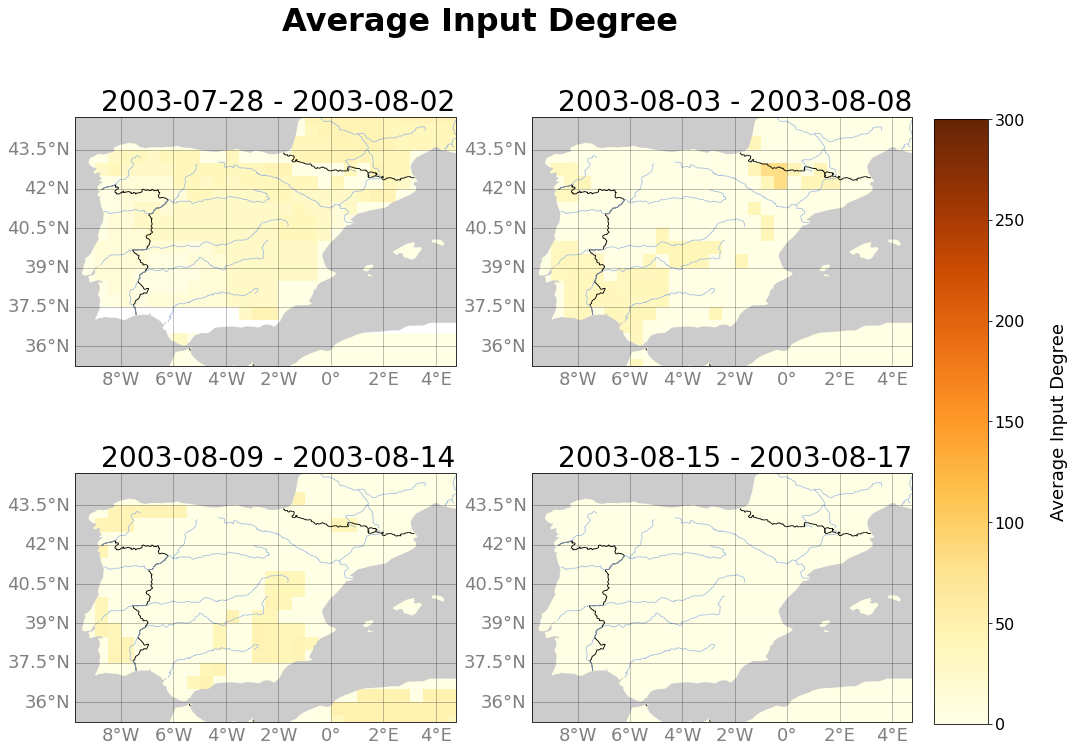

Unrecognized backend:  module://matplotlib_inline.backend_inline


<Figure size 432x288 with 0 Axes>

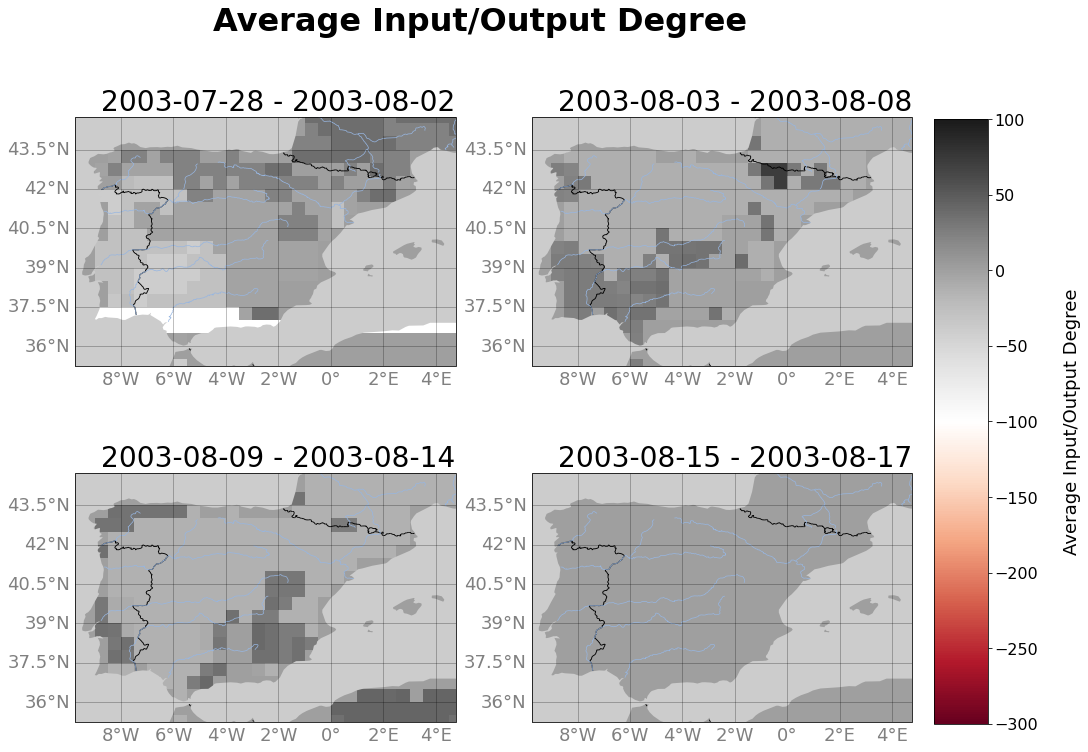

Unrecognized backend:  module://matplotlib_inline.backend_inline


<Figure size 432x288 with 0 Axes>

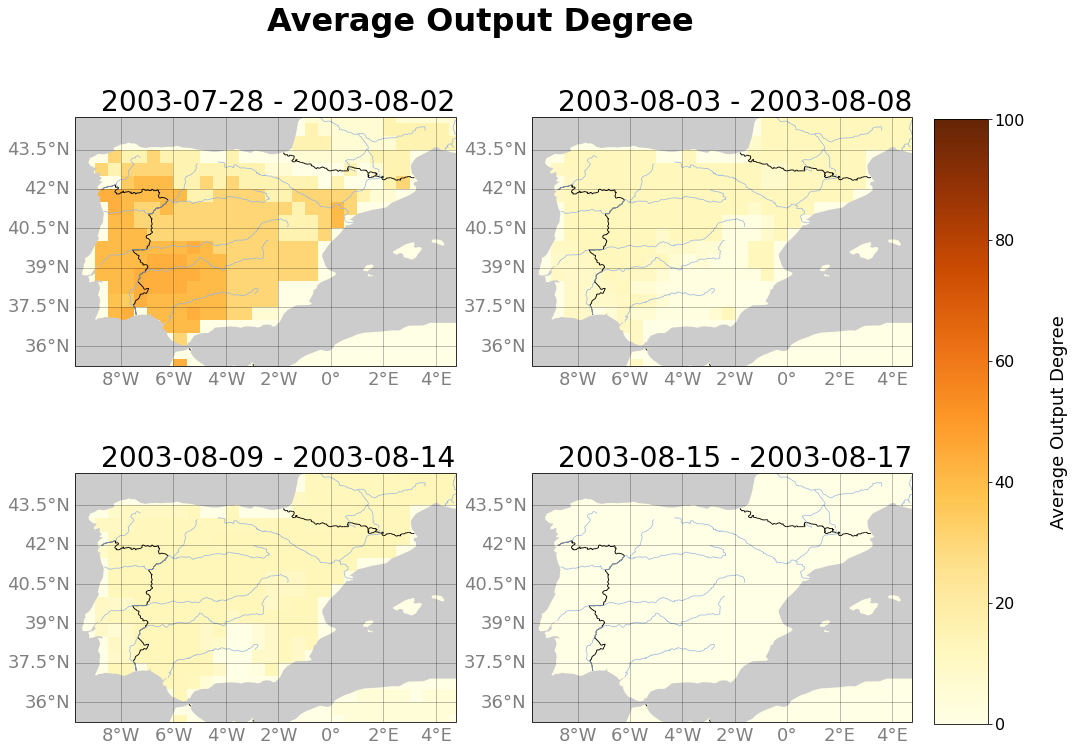

<Figure size 432x288 with 0 Axes>

In [6]:
%matplotlib inline

dic_coefs_per_period = prepare_coefficients_for_plotting(dic_stacks, sd, ed)
plot_coefficients_per_period(dic_coefs_per_period, all_coords_bbox, bounds, sd, ed, extent_name, resolution, path_png_out)


Saving the stacks as NetCDFs...

In [7]:
save_as_raster_files(dic_stacks, path_nc_out, extent_name, sd, ed, resolution, dimensions_board)

Creating minimaps for each network coefficient, showing their value for each day in the heatwave period

Unrecognized backend:  module://matplotlib_inline.backend_inline


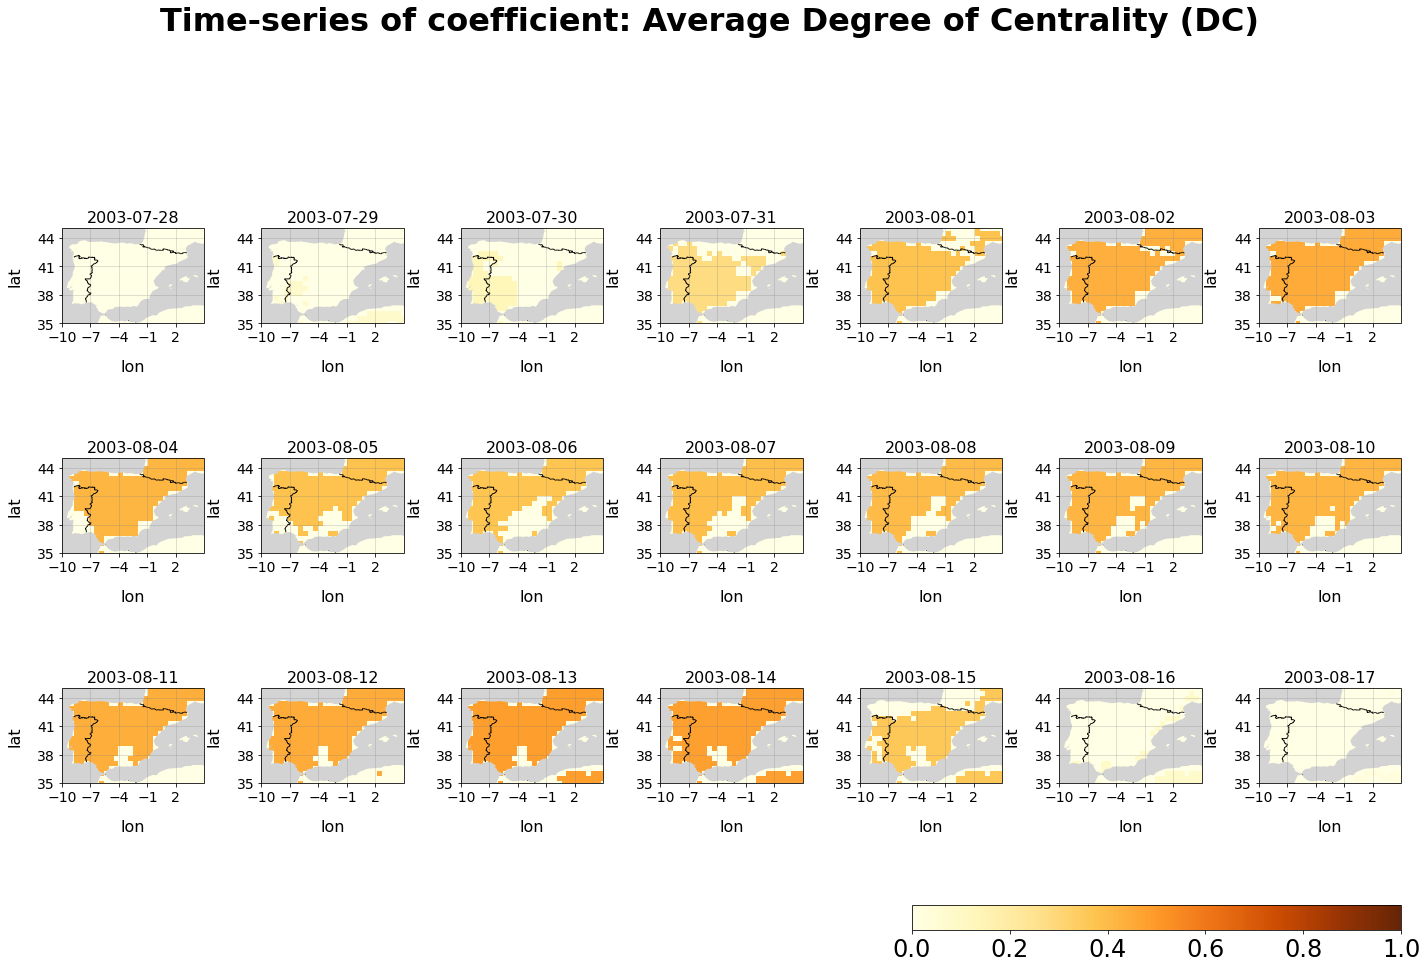

Unrecognized backend:  module://matplotlib_inline.backend_inline


<Figure size 432x288 with 0 Axes>

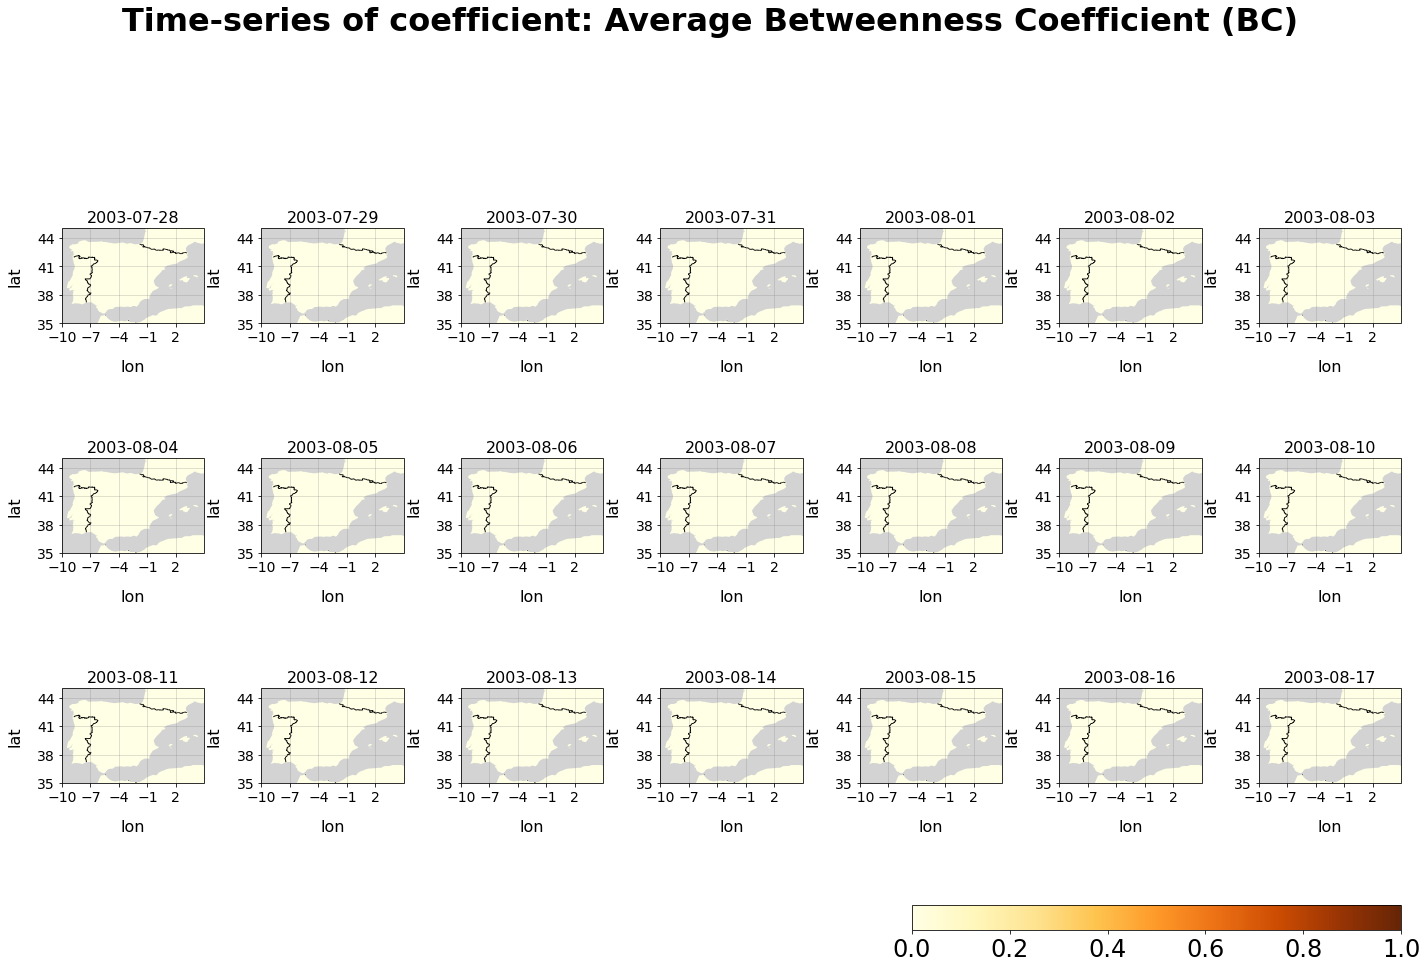

Unrecognized backend:  module://matplotlib_inline.backend_inline


<Figure size 432x288 with 0 Axes>

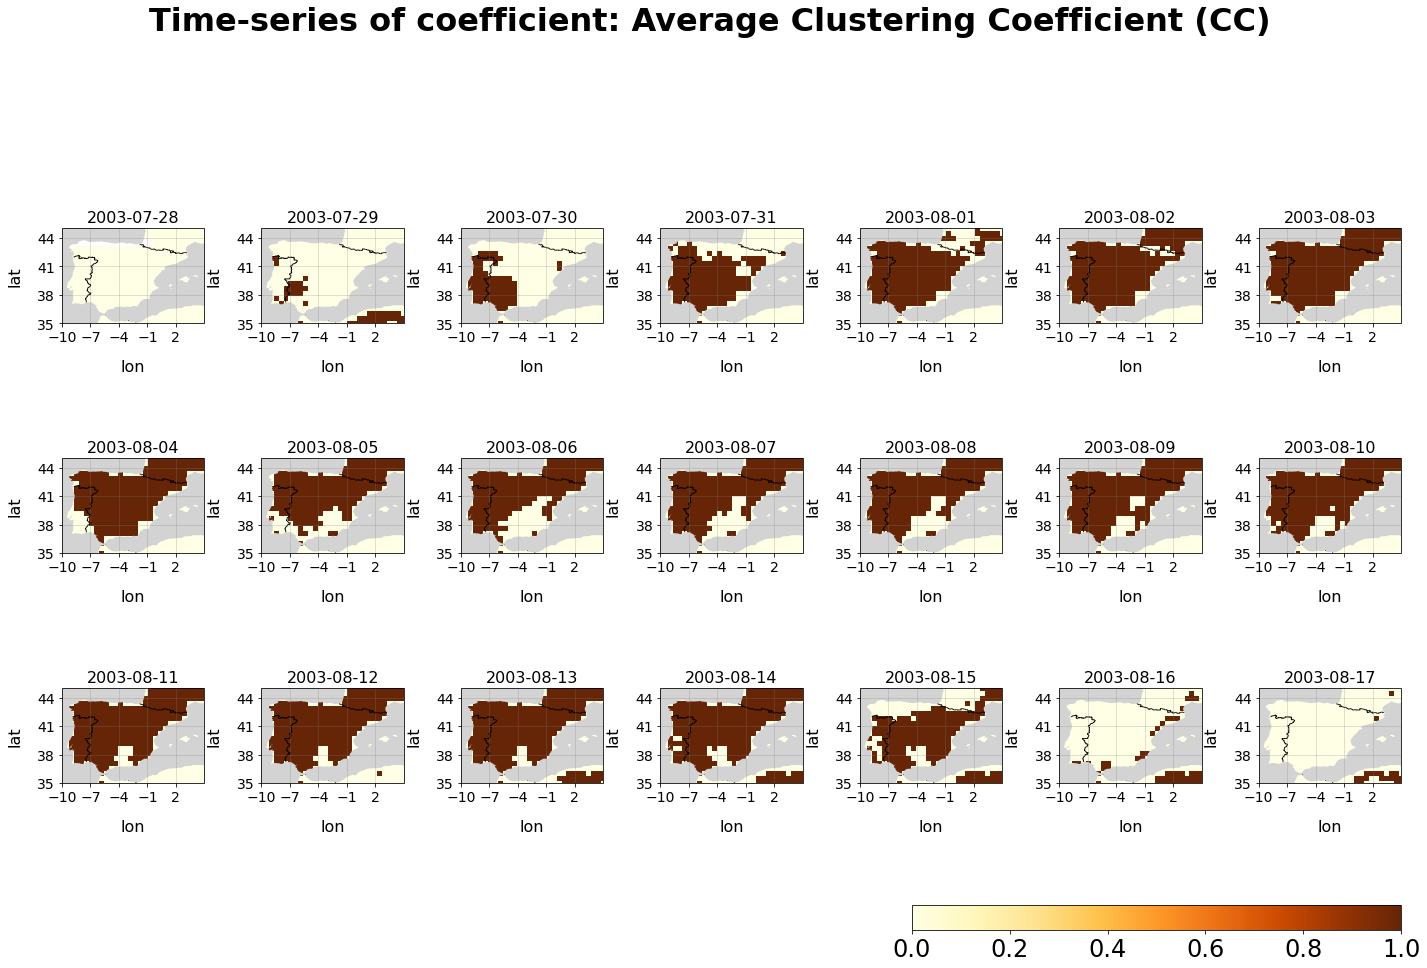

Unrecognized backend:  module://matplotlib_inline.backend_inline


<Figure size 432x288 with 0 Axes>

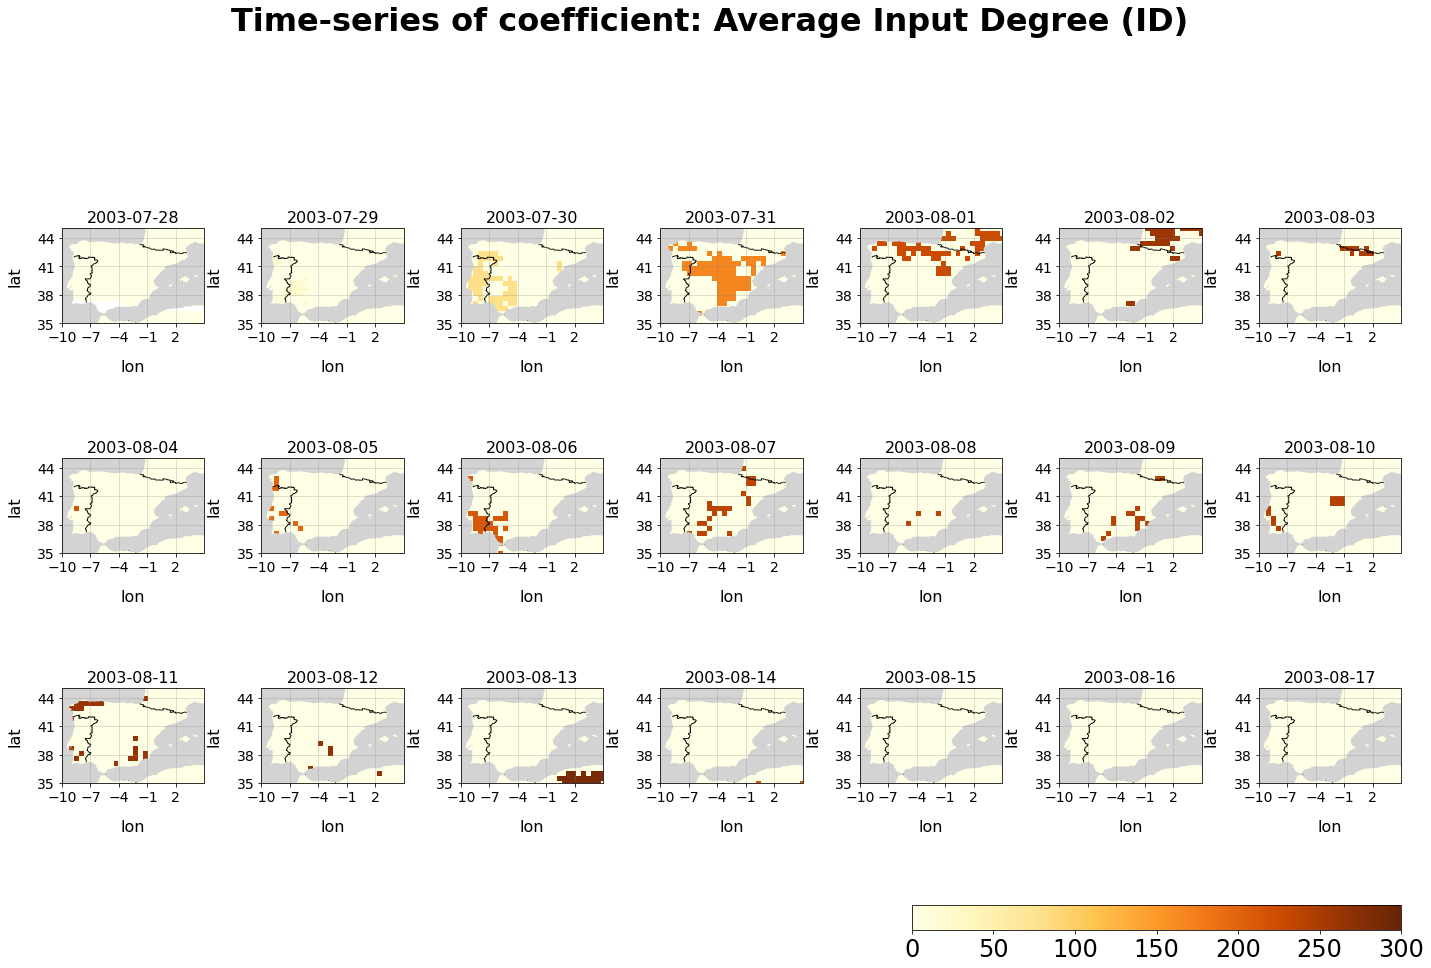

Unrecognized backend:  module://matplotlib_inline.backend_inline


<Figure size 432x288 with 0 Axes>

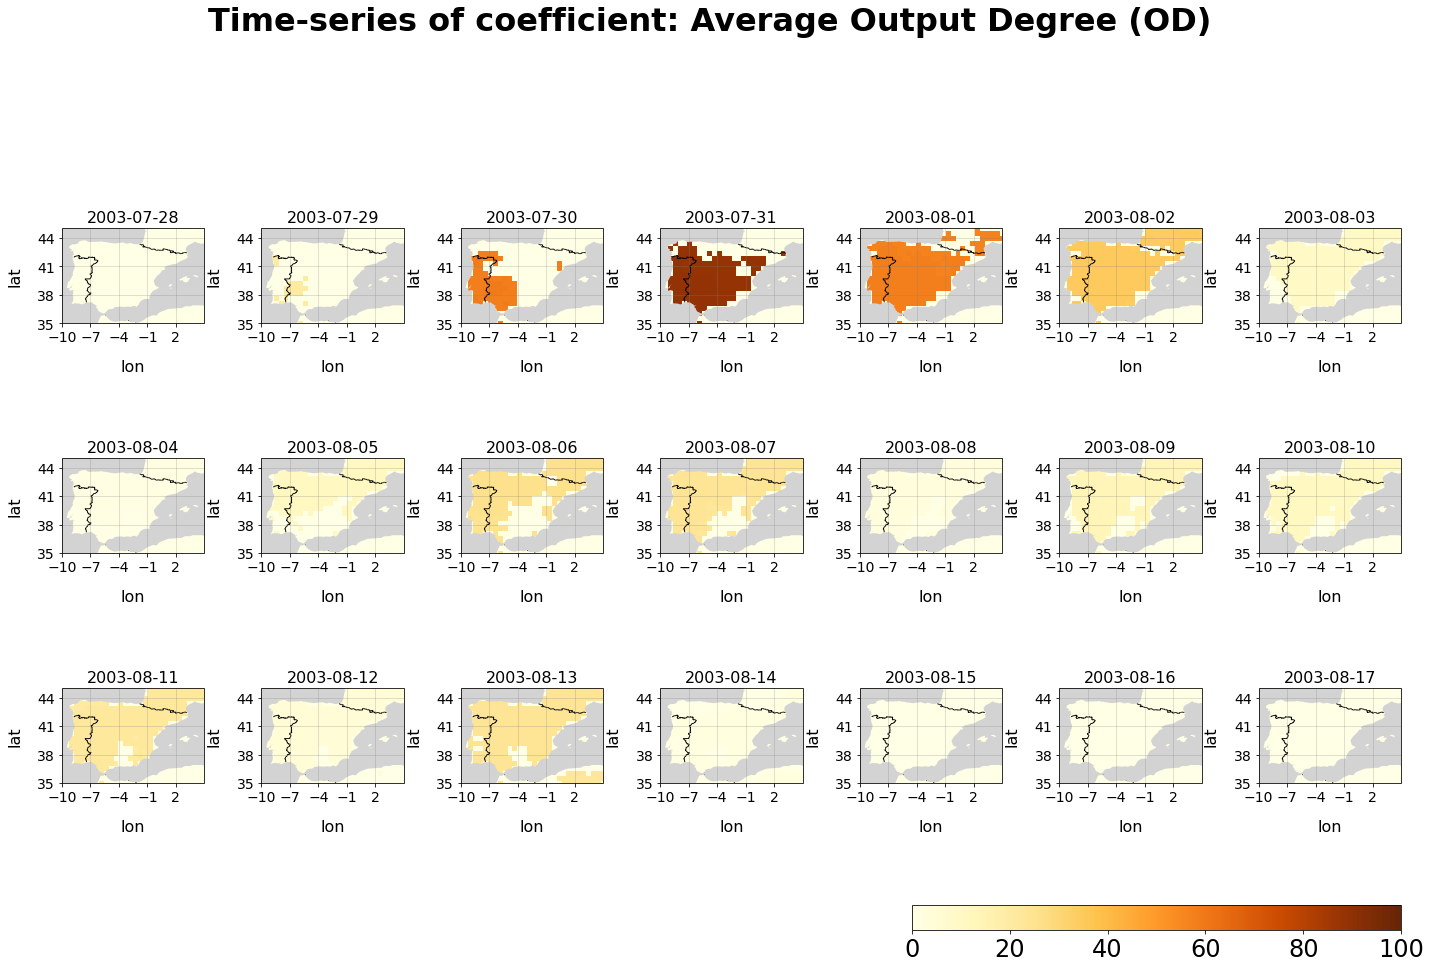

<Figure size 432x288 with 0 Axes>

In [8]:
coefs = ["DC", "BC", "CC", "ID", "OD"]
file_template = "CN_{0}_{1}_{2}_{3}_{4}.nc"
for coef in coefs:
    file_nc_in = file_template.format(extent_name, resolution, coef, sd.strftime("%Y-%m-%d"), ed.strftime("%Y-%m-%d"))
    dataset = xr.open_dataset(path_nc_out.format(file_nc_in), decode_times=True, use_cftime=True)
    plot_multiple_minimaps(dataset, coef, extent_name, resolution, sd, ed, path_png_out)
